In [1]:
import numpy as np
import pandas as pd

from lingam.utils import make_dot
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

from lingam import CausalBasedSimulator, CBSIDirectLiNGAM

## テストデータ

In [2]:
if False:
    causal_graph = np.array([
        [0.0, 0.0, 0.0, 3.0, 0.0, 0.0],
        [3.0, 0.0, 2.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 6.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [8.0, 0.0,-1.0, 0.0, 0.0, 0.0],
        [4.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    ])
    display(make_dot(causal_graph))

    n_samples = 1000
    e = np.random.uniform(-1.4142, 1.4142, size=(len(causal_graph), n_samples))
    X = np.linalg.pinv(np.eye(len(causal_graph)) - causal_graph) @ e
    X = X.T

causal_graph = np.array([
    [ 0.000,  0.000,  0.000,  0.895,  0.000,  0.000],
    [ 0.565,  0.000,  0.377,  0.000,  0.000,  0.000],
    [ 0.000,  0.000,  0.000,  0.895,  0.000,  0.000],
    [ 0.000,  0.000,  0.000,  0.000,  0.000,  0.000],
    [ 0.991,  0.000, -0.124,  0.000,  0.000,  0.000],
    [ 0.895,  0.000,  0.000,  0.000,  0.000,  0.000]
])

generate_error = lambda p: np.random.uniform(-p, p, size=1000)

error_vars = [0.2, 0.2, 0.2, 1.0, 0.2, 0.2]
params = [0.5 * np.sqrt(12 * v) for v in error_vars]
e = np.array([generate_error(p) for p in params])

X = np.linalg.pinv(np.eye(len(causal_graph)) - causal_graph) @ e
X = X.T

## CBSImplのインタフェイス

### ■ Property

#### endog_names_
内生変数のリスト。

['0', '1', '2', '3', '4', '5']


#### discrete_endog_names_
離散な内生変数のリスト。

['2', '5']


#### causal_order_
訓練結果の因果順序。

['3', '0', '2', '1', '4', '5']


#### exog_length_
外生変数の長さ。changing_exogに指定されたデータ長のチェックに利用。

1000


### ■ Method

#### get_parent_names(var_name)
指定変数の親変数名のリストを返す。

parent of 0 ['3']
parent of 4 ['0', '2']


#### get_data(var_names)
指定変数のデータを返す

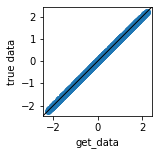

#### get_causal_order(changing_edges=None)
因果順序を返す。changing_edgesでエッジを付け替えたうえでの因果順序を返す。シミュレート時、エッジ増減後の因果順序を知るために使用する。

そのままの場合
['3', '0', '2', '1', '4', '5']
3->0を切って、2->0を追加
['3', '2', '0', '1', '4', '5']


#### Others 
因果探索アルゴリズムごとに誤差項の取り扱い方が変わる場合(未観測共通原因を持つ変数同士の誤差項はセットで並び替えなど)、set_exog_data(var_name, e), get_exog_data(is_shuffle)を実装します。

In [3]:
# CBSImplは公開してコンストラクタにユーザ実装を追加できるようにしてもよい。その機能が不要ならばCBSImpl系を公開する必要がない。

# 本当はX[2]、X[5]はdiscreteではないが検証のため設定
m = CBSIDirectLiNGAM(X, causal_graph, is_discrete=[False, False, True, False, False, True])

# プロパティ
display(Markdown("### ■ Property"))

display(Markdown("#### endog_names_\n内生変数のリスト。"))
print(m.endog_names_)

display(Markdown("#### discrete_endog_names_\n離散な内生変数のリスト。"))
print(m.discrete_endog_names_)

display(Markdown("#### causal_order_\n訓練結果の因果順序。"))
print(m.causal_order_)

display(Markdown("#### exog_length_\n外生変数の長さ。changing_exogに指定されたデータ長のチェックに利用。"))
print(m.exog_length_)

# メソッド
display(Markdown("### ■ Method"))

# 引数は変数名。Xがnumpyの場合は自動で列番号を数字にして列名とする
display(Markdown("#### get_parent_names(var_name)\n指定変数の親変数名のリストを返す。"))
parent_names = m.get_parent_names("0")
print("parent of 0", parent_names)
parent_names = m.get_parent_names("4")
print("parent of 4", parent_names)

display(Markdown("#### get_data(var_names)\n指定変数のデータを返す"))
X0 = m.get_data("0")
plt.figure(figsize=(2, 2))
plt.scatter(X[:, 0], X0)
plt.gca().set_aspect("equal", "box")
plt.axline((0, 0), (1, 1), color="black", lw=1)
plt.xlabel("get_data")
plt.ylabel("true data")
plt.show()

display(Markdown("#### get_causal_order(changing_edges=None)\n因果順序を返す。changing_edgesでエッジを付け替えたうえでの因果順序を返す。シミュレート時、エッジ増減後の因果順序を知るために使用する。"))
co = m.get_causal_order()
print("そのままの場合")
print(co)

print("3->0を切って、2->0を追加")
# キーは対象の変数、値はその変数の親ノード名。
changing_edges = {"0": ["2"]}
co = m.get_causal_order(changing_edges=changing_edges)
print(co)

display(Markdown("#### Others \n因果探索アルゴリズムごとに誤差項の取り扱い方が変わる場合(未観測共通原因を持つ変数同士の誤差項はセットで並び替えなど)、set_exog_data(var_name, e), get_exog_data(is_shuffle)を実装します。"))


## CausalBasedSimulator
インタフェイスは変わりありませんが、離散時の場合分けがなくなったので、プロパティや引数に与えるデータの仕様が変更になっています。以前よりシンプルで分かりやすくなっています。

### sim.train_result_
キーは変数名、値はその変数の、モデル、親変数名のリスト、訓練時の機械学習モデルの予測値、残差である。pandasで表示したため分からなくなっているが、変数名はすべてstr型。

,キー,モデル,親リスト,MLモデル予測値(のshape),MLモデル残差(のshape)
0,0,LinearRegression(),[3],"(1000,)","(1000,)"
1,1,LinearRegression(),"[0, 2]","(1000,)","(1000,)"
2,2,LinearRegression(),[3],"(1000,)","(1000,)"
3,3,None,[],None,"(1000,)"
4,4,LinearRegression(),"[0, 2]","(1000,)","(1000,)"
5,5,LinearRegression(),[0],"(1000,)","(1000,)"


### sim.run()

#### オプションなし

0 LinearRegression() ['3']
2 LinearRegression() ['3']
1 LinearRegression() ['0', '2']
4 LinearRegression() ['0', '2']
5 LinearRegression() ['0']


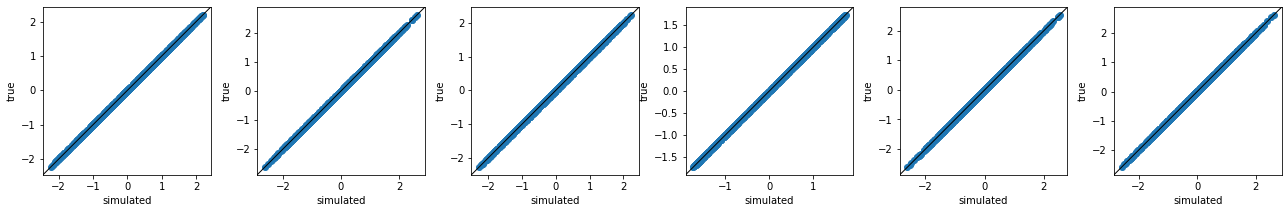

#### shuffle_residual=True

0 LinearRegression() ['3']
2 LinearRegression() ['3']
1 LinearRegression() ['0', '2']
4 LinearRegression() ['0', '2']
5 LinearRegression() ['0']


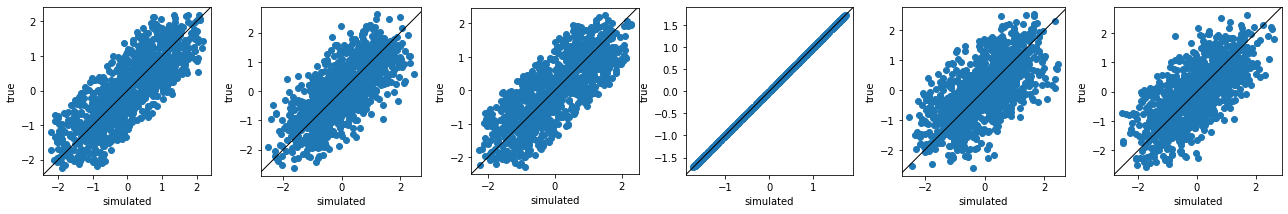

In [4]:
# コンストラクタは引数なし
sim = CausalBasedSimulator()

# 訓練
sim.train(X, causal_graph, causal_graph_type="DirectLiNGAM", models=None)

# 訓練結果(sim.trian_result_)
display(Markdown("### sim.train_result_\nキーは変数名、値はその変数の、モデル、親変数名のリスト、訓練時の機械学習モデルの予測値、残差である。pandasで表示したため分からなくなっているが、変数名はすべてstr型。"))
df = {}
for key, result in sim.train_result_.items():
    df[key] = {
        "キー": key,
        "モデル": result["model"],
        "親リスト": result["X_names"],
        "MLモデル予測値(のshape)": None if result["y_pred"] is None else result["y_pred"].shape,
        "MLモデル残差(のshape)": None if result["residual"] is None else result["residual"].shape,
    }
display(pd.DataFrame(df).T)

def vis(simulated, data):
    n_features = len(causal_graph)
    fig, axes = plt.subplots(1, n_features, figsize=(n_features*3, 3))
    for i in range(n_features):
        axes[i].scatter(simulated.iloc[:, i], data[:, i])
        axes[i].set_aspect("equal", "box")
        axes[i].axline((0, 0), (1, 1), color="black", lw=1)
        axes[i].set_xlabel("simulated")
        axes[i].set_ylabel("true")
    plt.tight_layout()
    plt.show()

display(Markdown("### sim.run()"))

# シミュレーション
display(Markdown("#### オプションなし"))
simulated = sim.run()
vis(simulated, X)

# シミュレーション2: 誤差変数並び替え
display(Markdown("#### shuffle_residual=True"))
simulated = sim.run(shuffle_residual=True)
vis(simulated, X)

# 質問中
# シミュレーション3: モデル変更(エッジ変更付き)　
#display(Markdown("#### changing_modelsを指定"))
# 0を外生化
#changing_models = {
#    "0": {"X_names": [], "model": None},
#}
#simulated = sim.run(changing_models=changing_models)
#vis(simulated, X)